# Exploring and Clustering of Neighborhoods of Toronto - Part I

In [55]:
# This is a cell to hide code snippets from displaying
# This must be at first cell!

from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


### Scraping the postal codes of Toronto's neighborhoods from webpage using beautifulsoup

In [3]:
#pip install "ipython-beautifulsoup[bs4]"

In [4]:
from bs4 import BeautifulSoup
import requests

In [5]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

In [6]:
canada_table = soup.find("table", attrs={"class": "wikitable sortable"})
#print(canada_table.prettify())

In [7]:
t_headers = []
for th in canada_table.find_all('th'):
    t_headers.append(th.text.replace('\n', ' ').strip()) # remove any newlines and extra spaces

# Get all the rows of table
table_data = []
for tr in canada_table.tbody.find_all("tr"):# find all tr's from table's tbody
    t_row = {}
    #Table row is stored in the form of
    # t_row = {'Postal Code': '', 'Borough': '', 'Neighborhood': ''}
    for td, th in zip(tr.find_all("td"), t_headers):
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)
#print(table_data)

#### Conversion of scraped data into pandas dataframe

In [8]:
canada_postal_codes = pd.DataFrame(table_data, columns = t_headers)
canada_postal_codes.head()

,Postal Code,Borough,Neighborhood
0,NaN,NaN,NaN
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [9]:
canada_postal_codes.dropna(inplace = True)
canada_postal_codes.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)
canada_postal_codes.head()

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Removing the cells with borough as 'Not assigned'

In [10]:
canada_postal_codes['Borough'].value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Name: Borough, dtype: int64

#### There are 77 boroughs as 'Not assigned' to be removed

In [11]:
canada_postal_codes = canada_postal_codes[canada_postal_codes.Borough != 'Not assigned'].reset_index(drop = True)
canada_postal_codes.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
canada_postal_codes.groupby(['PostalCode', 'Borough'])['Neighborhood'].value_counts()

PostalCode  Borough           Neighborhood                                                                                                                          
M1B         Scarborough       Malvern, Rouge                                                                                                                            1
M1C         Scarborough       Rouge Hill, Port Union, Highland Creek                                                                                                    1
M1E         Scarborough       Guildwood, Morningside, West Hill                                                                                                         1
M1G         Scarborough       Woburn                                                                                                                                    1
M1H         Scarborough       Cedarbrae                                                                                                                    

### Counting the number of cells in the final dataset

In [13]:
canada_postal_codes.shape

(103, 3)

# Exploring and Clustering of Neighborhoods of Toronto - Part II

Importing the downloaded CSV file and naming it as *geo_coor*

In [54]:
hide_me
print("This code will be hidden")
geo_coor = pd.read_csv('C:/Users/ryash/Google Drive/Coursera/IBM_capstone/Geospatial_Coordinates.csv')

This code will be hidden


In [15]:
geo_coor.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the geocordinate CSV file with the Toronto's postal codes data

In [16]:
final_postal_code_data = pd.merge(canada_postal_codes, geo_coor,left_on='PostalCode', right_on='PostalCode')
final_postal_code_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [17]:
final_postal_code_data.shape

(103, 5)

Extracting Toronto's geocordinate data using geopy

In [18]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Visualizing the Toronto's neighborhood

In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(final_postal_code_data['Latitude'],final_postal_code_data['Longitude'],final_postal_code_data['Borough'],final_postal_code_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Filtering the Toronto's data to keep only those Borough's that contain the word 'Toronto' in order to explore the neighborhoods

In [20]:
neigh_toronto = final_postal_code_data[final_postal_code_data['Borough'].str.contains ('Toronto')].reset_index(drop = True)
neigh_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [21]:
neigh_toronto.shape

(39, 5)

Visualizing the filtered Toronto's data on Map

In [22]:
# create map of Downtown Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neigh_toronto['Latitude'], neigh_toronto['Longitude'], neigh_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Defining Foursquare Credentials and Version

Utilizing the Foursquare API to explore the neighborhoods and segment them. Foursquare credentials are hidden

In [24]:
hide_me
print ("this code will be hidden")
CLIENT_ID = 'R4STRF2JJMU0M0V5W1Z0PXAYI3DYNF2NGV1GPEGDJRALW50R' # your Foursquare ID
CLIENT_SECRET = 'BNJARBKMIHZML2TRUEM34TWENV1J30M0SSFAL4UVXHB3PR0X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

this code will be hidden


#### Obtaining the top 100 venues that are in Toronto within a radius of 800 meters.

Creating the GET request URL. Naming the URL as url and sending the GET request. Also, creating a function to extract the information about the neighborhoods in Toronto.

In [28]:
LIMIT = 100
radius = 800
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        
       

Writing the code to run the above function on each neighborhood and creating a new dataframe called *toronto_venues*.

In [27]:
toronto_venues = getNearbyVenues(names=neigh_toronto['Neighborhood'],
                                   latitudes=neigh_toronto['Latitude'],
                                   longitudes=neigh_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


#### checking the size of the resulting dataframe

In [29]:
print(toronto_venues.shape)
toronto_venues.head()

(2805, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


 Counting the venues returned for each neighborhood

In [30]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,100,100,100,100,100,100
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",59,59,59,59,59,59
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",30,30,30,30,30,30
Central Bay Street,100,100,100,100,100,100
Christie,63,63,63,63,63,63
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,79,79,79,79,79,79


Calculating the unique categories can be extrated from all the returned venues

In [31]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 288 uniques categories.


## Analyzing each neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tunnel,Udon Restaurant,University,Vege

Examining the new dataframe's size

In [33]:
toronto_onehot.shape

(2805, 288)

Moving the neighborhood column to the first column

In [34]:
Neighborhood = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', Neighborhood)
toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tunnel,Udon Restaurant,University,Vege

#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tunnel,Udon Restaurant,University,Vege

Confirming the new size

In [36]:
toronto_grouped.shape

(39, 288)

#### Printing each neighborhood along with the top 5 most common venues

In [37]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                 venue  freq
0          Coffee Shop  0.10
1                 Café  0.06
2           Restaurant  0.05
3                Hotel  0.05
4  Japanese Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.06
2           Restaurant  0.05
3               Bakery  0.04
4  Arts & Crafts Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Fast Food Restaurant  0.08
1    Light Rail Station  0.05
2                  Park  0.05
3            Restaurant  0.03
4         Burrito Place  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Harbor / Marina   0.1
1        Boat or Ferry   0.1
2      Airport Service   0.1
3     Airport Terminal   0.1
4  Rental Car Location   0.1


----Centr

#### Placing the above result into *pandas* dataframe

Writing a function to sort the venues in descending order.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant,Park,Beer Bar,Bakery,Seafood Restaurant,Breakfast Spot
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Restaurant,Furniture / Home Store,Arts & Crafts Store,Bakery,Bar,Gift Shop,Music Venue,Performing Arts Venue
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Park,Light Rail Station,Italian Restaurant,Burrito Place,Harbor / Marina,Pizza Place,Coffee Shop,Grocery Store,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Harbor / Marina,Rental Car Location,Boat or Ferry,Airport Service,Airport Lounge,Sculpture Garden,Coffee Shop,Airport Gate,Airport Food Court
4,Central Bay Street,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Clothing Store,Ramen Restaurant,Park,Italian Restaurant,Sushi Restaurant,French Restaurant


Finging the best cluster number (K)

In [43]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [44]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(k_means.inertia_)


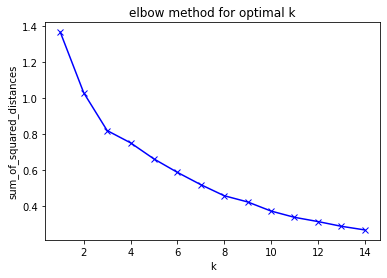

In [45]:
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

Based on elbow method, it does not have an obvious point where the curve starts flattening out. However, 5 appears to be the optimum number after manual evaluation of different values of k.

### Clustering neighborhoods

Running *k*-means to cluster the neighborhood into 5 clusters.

In [46]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 0, 2, 0, 0, 2, 2])

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [47]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neigh_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged= toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Theater,Bakery,Café,Restaurant,Pub,Italian Restaurant,Breakfast Spot,Performing Arts Venue
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Bubble Tea Shop,Park,Bookstore,Italian Restaurant,Café,Sushi Restaurant,Gastropub,Yoga Studio,Diner
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Diner,Ramen Restaurant,Clothing Store,Middle Eastern Restaurant,Theater,Plaza
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Seafood Restaurant,Gastropub,Cosmetics Shop,American Restaurant,Creperie,Bookstore
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Sandwich Place,Café,Breakfast Spot,Bank,Bar,Coffee Shop,Japanese Restaurant,Grocery Store,Dessert Shop


Visualizing the resulting clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'],toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining clusters

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Bubble Tea Shop,Park,Bookstore,Italian Restaurant,Café,Sushi Restaurant,Gastropub,Yoga Studio,Diner
2,"Garden District, Ryerson",0,Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Diner,Ramen Restaurant,Clothing Store,Middle Eastern Restaurant,Theater,Plaza
3,St. James Town,0,Coffee Shop,Café,Restaurant,Japanese Restaurant,Seafood Restaurant,Gastropub,Cosmetics Shop,American Restaurant,Creperie,Bookstore
5,Berczy Park,0,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant,Park,Beer Bar,Bakery,Seafood Restaurant,Breakfast Spot
6,Central Bay Street,0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Clothing Store,Ramen Restaurant,Park,Italian Restaurant,Sushi Restaurant,French Restaurant
8,"Richmond, Adelaide, King",0,Coffee Shop,Café,Hotel,Theater,Restaurant,Gym,Art Gallery,Sushi Restaurant,Japanese Restaurant,Tea Room
10,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Hotel,Brewery,Park,Japanese Restaurant,Boat or Ferry,Deli / Bodega,Baseball Stadium,Sushi Restaurant,Restaurant
11,"Little Portugal, Trinity",0,Bar,Café,Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Cocktail Bar,Bakery,Park,Japanese Restaurant,Bookstore
13,"Toronto Dominion Centre, Design Exchange",0,Hotel,Coffee Shop,Café,Restaurant,Italian Restaurant,Seafood Restaurant,American Restaurant,Concert Hall,Park,Gym
14,"Brockton, Parkdale Village, Exhibition Place",0,Coffee Shop,Café,Restaurant,Furniture / Home Store,Arts & Crafts Store,Bakery,Bar,Gift Shop,Music Venue,Performing Arts Venue


Cluster 0: 
Clusters of neighborhoods with label 0 have a multitude of places to grab quick cuppa (coffee shops) and unwind at various cafes, with a few hotels and Japanese resturants thrown in for a good measure. 

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,1,Garden,Playground,Pet Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


Cluster 1: Cluster 1 has one neighborhood with proximity to a garden and a play area. However, it does not have many resturants, coffee shops or cafes.

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",2,Coffee Shop,Park,Theater,Bakery,Café,Restaurant,Pub,Italian Restaurant,Breakfast Spot,Performing Arts Venue
4,The Beaches,2,Pub,Sandwich Place,Café,Breakfast Spot,Bank,Bar,Coffee Shop,Japanese Restaurant,Grocery Store,Dessert Shop
7,Christie,2,Korean Restaurant,Grocery Store,Coffee Shop,Park,Café,Diner,Cocktail Bar,Karaoke Bar,Indian Restaurant,Pizza Place
9,"Dufferin, Dovercourt Village",2,Park,Coffee Shop,Portuguese Restaurant,Bakery,Pharmacy,Gym,Grocery Store,Bar,Camera Store,Café
12,"The Danforth West, Riverdale",2,Greek Restaurant,Coffee Shop,Pub,Café,Spa,Italian Restaurant,Fast Food Restaurant,Yoga Studio,Pizza Place,Pet Store
15,"India Bazaar, The Beaches West",2,Indian Restaurant,Grocery Store,Fast Food Restaurant,Restaurant,Park,Brewery,Sandwich Place,Café,Coffee Shop,Gym
17,Studio District,2,Café,Coffee Shop,Bar,Bakery,Brewery,Sandwich Place,Diner,Pizza Place,Gastropub,Sushi Restaurant
20,Davisville North,2,Coffee Shop,Italian Restaurant,Pizza Place,Café,Fast Food Restaurant,Park,Dog Run,Food & Drink Shop,Sushi Restaurant,Deli / Bodega
21,"Forest Hill North & West, Forest Hill Road Park",2,Italian Restaurant,Park,Trail,Café,Bank,Bakery,Bagel Shop,Gym / Fitness Center,Pharmacy,Coffee Shop
22,"High Park, The Junction South",2,Italian Restaurant,Café,Park,Thai Restaurant,Bar,Antique Shop,Cajun / Creole Restaurant,Deli / Bodega,Arts & Crafts Store,Coffee Shop


Cluster 2: Cluster 2 neighborhood boasts of as array of resturants with diverse cuisines including Italian, Korean, Indian, Thai and Portuguese and coffee shops. The cluster predominantly contains Italian cuisine resturants with a smattering of Sushi places as well. Furthermore, there are utility places in the vicinity such as grocery stores and parks.

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",3,Grocery Store,Park,Candy Store,Sandwich Place,Café,Japanese Restaurant,Gym,Thai Restaurant,Dog Run,Discount Store
33,Rosedale,3,Park,Trail,Playground,Bank,Grocery Store,Candy Store,Yoga Studio,Donut Shop,Distribution Center,Dive Bar


Cluster 3 : It has neighborhoods with mostly parks and a trail and not many eating places

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,4,Restaurant,Bus Line,Bookstore,Café,Coffee Shop,Gym / Fitness Center,Park,Dog Run,Doner Restaurant,Donut Shop


Cluster 4: Its the only neighborhood with a bus line and quite a few bookstores

In [56]:
# This is a cell to hide code snippets from displaying
# This must be at first cell!

from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')
